In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('.venv/lib/python3.7/site-packages/')

In [7]:
import torch
import torch.nn as nn
import torchvision
from callback.logging import TensorBoardLogger
from callback import TDVAEVisualization, ProgressCheck
from common.transformation import RolloutImage
from model import TDVAE
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from common import set_random_seed
from runner import ModelRunner

In [4]:
# Load MNIST dataset. We will use the training data only because our task so far is to evaluate rollout not to 
# classify the numbers
training_set = torchvision.datasets.MNIST('data/', 
                                          train=True, 
                                          download=True, 
                                          transform=torchvision.transforms.Compose([
                                              torchvision.transforms.ToTensor(),
                                              RolloutImage(time_steps=20, offset=2),
                                              torchvision.transforms.Lambda(lambda x: torch.flatten(x, start_dim=1))
                                          ]))
                                            

In [5]:
# Preserving the original parameters given in the paper
set_random_seed(42)
model = TDVAE(belief_size=50, 
              latent_size=8, 
              d_map_size=50,
              obs_size=28*28,
              minified_obs_size=28*28,
              decoder_activation='tanh',
              decoder_hidden_dims=[200, 200],
              pre_processing_activation='relu',
              pre_processing_hidden_dims=[28*28],
              max_time_diff=4)

In [30]:
# Define what we want to log
loss_logger = TensorBoardLogger(out_dir='board', 
                                update_frequency_type='batch', 
                                update_frequency=10)

img_logger = TensorBoardLogger(id=loss_logger.id,
                               out_dir='board', 
                               update_frequency_type='batch', 
                               update_frequency=100)

training_visualization = TDVAEVisualization(model=model, 
                                            logger=img_logger,
                                            data_set=training_set, 
                                            batch_size=10,
                                            context_size=15,
                                            rollout_size=5)

progress_check = ProgressCheck(display_measures={"total_loss", "kl_t1_loss", "kl_t2_loss", "x_loss"},
                               update_frequency_type='batch',
                               update_frequency=50)

callbacks = [loss_logger, training_visualization, progress_check]

In [ ]:
runner = ModelRunner(model)
runner.train(training_set=training_set,
             epochs=40,
             batch_size=64,
             optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
             callbacks=callbacks)

[Epoch 0 Batch 0] kl_t1_loss: 1.1547 kl_t2_loss: 3.4768 x_loss: 152.2052 total_loss: 156.8367
[Epoch 0 Batch 50] kl_t1_loss: 1.3413 kl_t2_loss: 3.8350 x_loss: 145.8645 total_loss: 151.0407
[Epoch 0 Batch 100] kl_t1_loss: 1.2645 kl_t2_loss: 3.3049 x_loss: 157.6747 total_loss: 162.2442
[Epoch 0 Batch 150] kl_t1_loss: 1.2586 kl_t2_loss: 3.8831 x_loss: 155.1549 total_loss: 160.2967
[Epoch 0 Batch 200] kl_t1_loss: 1.0498 kl_t2_loss: 3.8505 x_loss: 138.0778 total_loss: 142.9782
[Epoch 0 Batch 250] kl_t1_loss: 1.6943 kl_t2_loss: 4.0503 x_loss: 138.7240 total_loss: 144.4686
[Epoch 0 Batch 300] kl_t1_loss: 1.4888 kl_t2_loss: 3.7870 x_loss: 156.3606 total_loss: 161.6364
[Epoch 0 Batch 350] kl_t1_loss: 1.1093 kl_t2_loss: 3.9751 x_loss: 143.6713 total_loss: 148.7557
[Epoch 0 Batch 400] kl_t1_loss: 1.1542 kl_t2_loss: 4.1807 x_loss: 142.2892 total_loss: 147.6241
[Epoch 0 Batch 450] kl_t1_loss: 1.0095 kl_t2_loss: 4.1115 x_loss: 150.3284 total_loss: 155.4494
[Epoch 0 Batch 500] kl_t1_loss: 1.0702 kl_t

[Epoch 4 Batch 500] kl_t1_loss: 0.8496 kl_t2_loss: 5.2750 x_loss: 105.8985 total_loss: 112.0232
[Epoch 4 Batch 550] kl_t1_loss: 0.9343 kl_t2_loss: 4.6663 x_loss: 107.3064 total_loss: 112.9070
[Epoch 4 Batch 600] kl_t1_loss: 0.8102 kl_t2_loss: 5.0404 x_loss: 100.2228 total_loss: 106.0734
[Epoch 4 Batch 650] kl_t1_loss: 0.9429 kl_t2_loss: 5.1366 x_loss: 101.8070 total_loss: 107.8865
[Epoch 4 Batch 700] kl_t1_loss: 0.7852 kl_t2_loss: 5.0695 x_loss: 104.6740 total_loss: 110.5287
[Epoch 4 Batch 750] kl_t1_loss: 0.8946 kl_t2_loss: 4.8408 x_loss: 112.5909 total_loss: 118.3262
[Epoch 4 Batch 800] kl_t1_loss: 0.8914 kl_t2_loss: 5.3459 x_loss: 109.2046 total_loss: 115.4419
[Epoch 4 Batch 850] kl_t1_loss: 0.7949 kl_t2_loss: 4.9291 x_loss: 103.2610 total_loss: 108.9851
[Epoch 4 Batch 900] kl_t1_loss: 0.8027 kl_t2_loss: 5.2477 x_loss: 102.0808 total_loss: 108.1311
[Epoch 5 Batch 0] kl_t1_loss: 0.9663 kl_t2_loss: 5.0613 x_loss: 96.7779 total_loss: 102.8055
[Epoch 5 Batch 50] kl_t1_loss: 0.8534 kl_t2

In [12]:
test = training_set.data[:5].clone().detach() / 255.
rollout = RolloutImage(10, 2)
imgs = []
for i in range(test.size(0)): 
    img = rollout(torch.unsqueeze(test[i], dim=0))
    img = torch.flatten(img, start_dim=1)
    imgs.append(img)
test = torch.stack(imgs, dim=0)    

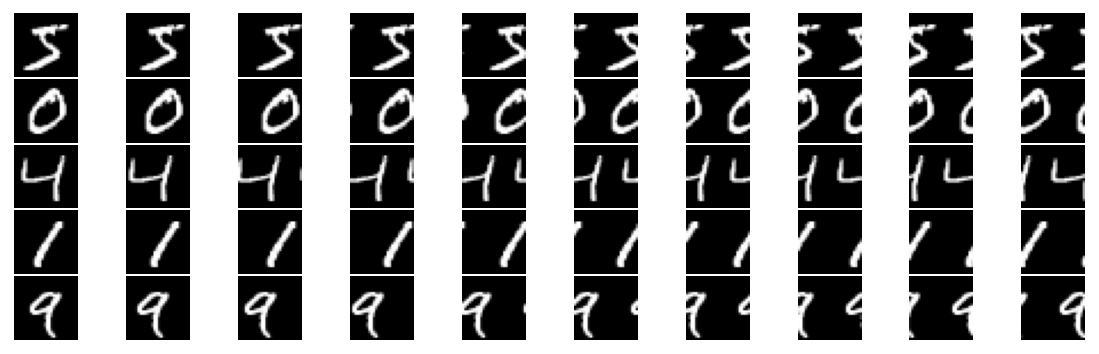

In [8]:
fig = plt.figure(0, figsize = (10,3))
fig.clf()
gs = gridspec.GridSpec(test.size(0),test.size(1))
gs.update(wspace = 0.025, hspace = 0.025)

for i in range(test.size(0)):
    img = test[i]
    for n in range(test.size(1)):
        axes = plt.subplot(gs[i,n])
        axes.imshow(img[n,:].reshape(28,28), cmap = 'gray')
        axes.axis('off')
plt.show()

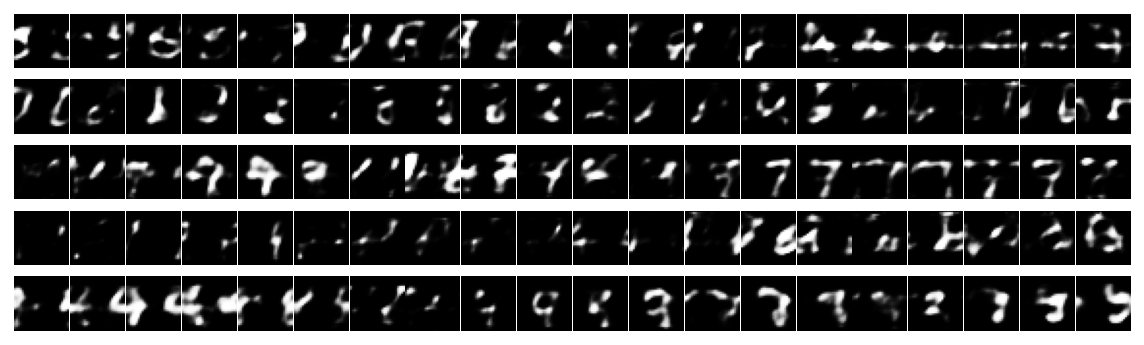

In [9]:
future = model.rollout(test, 20)
fig = plt.figure(0, figsize = (10,3))
fig.clf()
gs = gridspec.GridSpec(future.size(0),future.size(1))
gs.update(wspace = 0.025, hspace = 0.025)

for i in range(future.size(0)):
    img = future[i]
    for n in range(future.size(1)):
        axes = plt.subplot(gs[i,n])
        axes.imshow(img[n,:].reshape(28,28), cmap = 'gray')
        axes.axis('off')
plt.show()

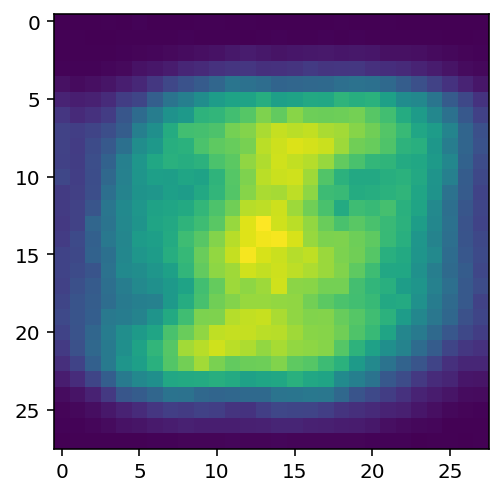

In [16]:
plt.imshow(future[0][0].reshape(28,28))

In [30]:
test[0][0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [24]:
from common import calculate_gaussian_kl_divergence
mu_q = torch.tensor([[2]])
log_var_q = torch.log(torch.tensor([[3]]))
mu_p = torch.tensor([[4]])
log_var_p = torch.log(torch.tensor([[5]]))
calculate_gaussian_kl_divergence([mu_q, log_var_q], [mu_p, log_var_p])

tensor([0.2708])

In [25]:
q = torch.distributions.normal.Normal(mu_q, torch.exp(log_var_q))
p = torch.distributions.normal.Normal(mu_p, torch.exp(log_var_p))
torch.distributions.kl.kl_divergence(q, p)

tensor([[0.2708]])

In [16]:
import torch.nn.functional as F
input_ = torch.sigmoid(torch.randn((3, 2), requires_grad=True))
target = torch.rand((3, 2), requires_grad=False)
loss = F.binary_cross_entropy(input_, target)

In [17]:
loss

tensor(0.9234, grad_fn=<BinaryCrossEntropyBackward0>)

In [18]:
input_

tensor([[0.2470, 0.5913],
        [0.2988, 0.5012],
        [0.6072, 0.7429]], grad_fn=<SigmoidBackward0>)

In [19]:
target

tensor([[0.9518, 0.4647],
        [0.8742, 0.1464],
        [0.7429, 0.2749]])

In [20]:
bce = -(target * torch.log(input_) + (1 - target) * torch.log(1 - input_))
bce

tensor([[1.3446, 0.7231],
        [1.1006, 0.6948],
        [0.6109, 1.0667]], grad_fn=<NegBackward0>)

In [21]:
torch.sum(bce, dim=1)

tensor([2.0677, 1.7954, 1.6776], grad_fn=<SumBackward1>)

In [22]:
import numpy as np
np.random.choice([18])

18

In [23]:
idx = torch.tensor([0,2,2])
target[idx, :]

tensor([[0.9518, 0.4647],
        [0.7429, 0.2749],
        [0.7429, 0.2749]])

In [29]:
torch.gather(target, 1, idx)

RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [32]:
target[..., None].expand(-1, -1, 1)

tensor([[[0.9518],
         [0.4647]],

        [[0.8742],
         [0.1464]],

        [[0.7429],
         [0.2749]]])

In [41]:
idx[..., None].expand(3, 4)

tensor([[0, 0, 0, 0],
        [2, 2, 2, 2],
        [2, 2, 2, 2]])

In [49]:
bs = torch.tensor([[[[[1,2,3,4], [5,6,7,8]]], [[[9,10,11,12], [13,14,15,16]]], [[[17,18,19,20], [21,22,23,24]]], [[[25,26,27,28], [29,30,31,32]]], [[[33,34,35,36], [37,38,39,40]]]], [[[[41,42,43,44], [45,46,47,48]]], [[[49,50,51,52], [53,54,55,56]]], [[[57,58,59,60], [61,62,63,64]]], [[[65,66,67,68], [60,70,71,72]]], [[[73,74,75,76], [77,78,79,80]]]], [[[[81,82,83,84], [85,86,87,88]]], [[[89,90,91,92], [93,94,95,96]]], [[[1,2,3,4], [5,6,7,8]]], [[[97,98,99,100], [101,102,103,104]]], [[[105,106,107,108], [109,110,111,112]]]]])[:, :, 0, :, :]
bs.shape

torch.Size([3, 5, 2, 4])

In [51]:
idx = torch.tensor([3, 2, 1])
idx_exp = idx[..., None, None, None].expand(-1, -1, bs.size(2), bs.size(3))
bs_t1 = torch.gather(bs, 1, idx_exp).view(-1, bs.size(2), bs.size(3))

In [52]:
idx_exp

tensor([[[[3, 3, 3, 3],
          [3, 3, 3, 3]]],


        [[[2, 2, 2, 2],
          [2, 2, 2, 2]]],


        [[[1, 1, 1, 1],
          [1, 1, 1, 1]]]])

In [56]:
bs_t1

tensor([[[25, 26, 27, 28],
         [29, 30, 31, 32]],

        [[57, 58, 59, 60],
         [61, 62, 63, 64]],

        [[89, 90, 91, 92],
         [93, 94, 95, 96]]])

In [54]:
bs

tensor([[[[  1,   2,   3,   4],
          [  5,   6,   7,   8]],

         [[  9,  10,  11,  12],
          [ 13,  14,  15,  16]],

         [[ 17,  18,  19,  20],
          [ 21,  22,  23,  24]],

         [[ 25,  26,  27,  28],
          [ 29,  30,  31,  32]],

         [[ 33,  34,  35,  36],
          [ 37,  38,  39,  40]]],


        [[[ 41,  42,  43,  44],
          [ 45,  46,  47,  48]],

         [[ 49,  50,  51,  52],
          [ 53,  54,  55,  56]],

         [[ 57,  58,  59,  60],
          [ 61,  62,  63,  64]],

         [[ 65,  66,  67,  68],
          [ 60,  70,  71,  72]],

         [[ 73,  74,  75,  76],
          [ 77,  78,  79,  80]]],


        [[[ 81,  82,  83,  84],
          [ 85,  86,  87,  88]],

         [[ 89,  90,  91,  92],
          [ 93,  94,  95,  96]],

         [[  1,   2,   3,   4],
          [  5,   6,   7,   8]],

         [[ 97,  98,  99, 100],
          [101, 102, 103, 104]],

         [[105, 106, 107, 108],
          [109, 110, 111, 112]]]])

In [7]:
t1 = torch.load('t2.pt')
t2 = torch.load('t2_other.pt')

In [8]:
t1

tensor([12,  4,  4,  5, 13, 10,  7,  5, 13,  4,  3,  6, 16, 15, 14,  7,  5, 13,
        11,  7, 13,  5,  4,  3, 18, 14, 11,  6,  6,  2, 13,  6, 13,  6, 11, 10,
         7,  8,  3, 16,  6, 15,  3, 10,  7,  6,  5,  2, 14, 13, 13, 15,  4,  4,
         2,  6,  4, 11, 15, 15, 10, 12,  2,  7])

In [9]:
t2

tensor([[12,  4,  4,  5, 13, 10,  7,  5, 13,  4,  3,  6, 16, 15, 14,  7,  5, 13,
         11,  7, 13,  5,  4,  3, 18, 14, 11,  6,  6,  2, 13,  6, 13,  6, 11, 10,
          7,  8,  3, 16,  6, 15,  3, 10,  7,  6,  5,  2, 14, 13, 13, 15,  4,  4,
          2,  6,  4, 11, 15, 15, 10, 12,  2,  7]])

In [11]:
x1 = torch.load('true_x_t2.pt')
x2 = torch.load('true_x_t2_other.pt')

In [12]:
print(x1.shape)
print(x2.shape)

torch.Size([64, 784])
torch.Size([64, 784])


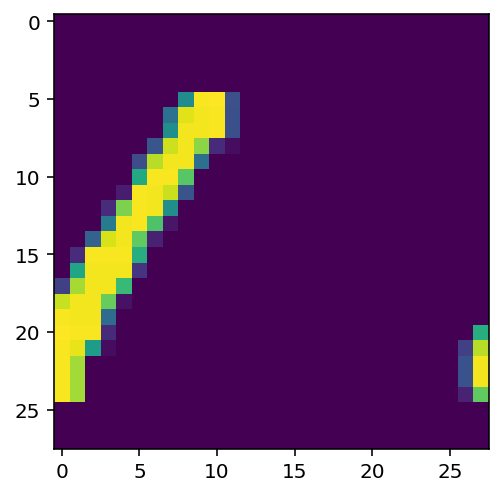

In [13]:
plt.imshow(x1[3].reshape(28, 28))

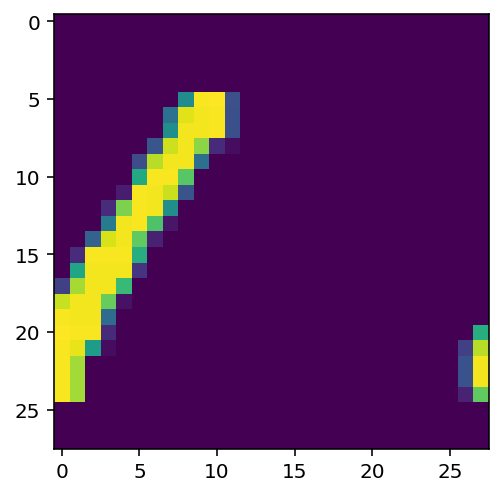

In [14]:
plt.imshow(x2[3].reshape(28, 28))

In [15]:
(x1 == x2).all()

tensor(True)